In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [23]:
dataset=pd.read_csv('/content/housing.csv')
dataset=dataset.dropna()
dataset.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


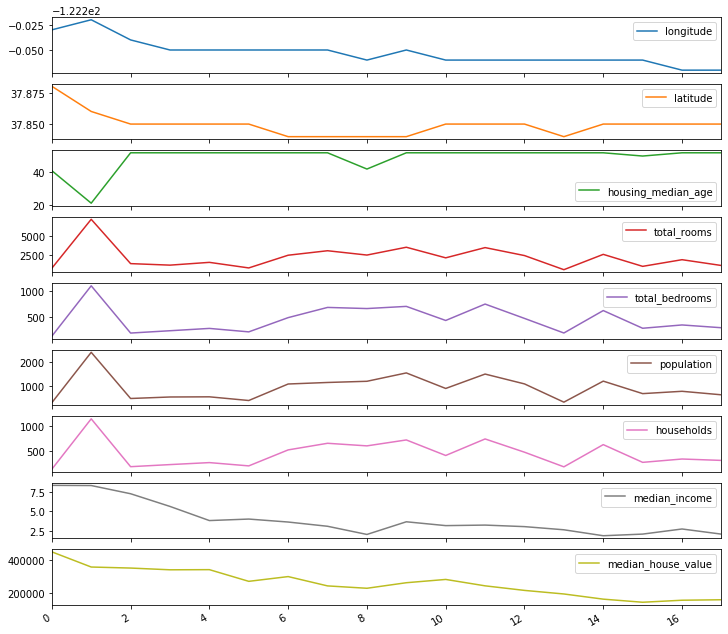

In [24]:
def plottheDataset():
  # Plot the Graphs
  dataset.head(18).plot.line(subplots=True,figsize=(12,12))
  

plottheDataset()

In [0]:
Y=dataset['median_house_value']
#X=dataset.iloc[:,'longitude':'latitude']
X =dataset.iloc[:, [0,1,2,3,4,5,6,7]]

In [0]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)
x_train_np=x_train.to_numpy()
y_train_np=y_train.to_numpy()
x_test_np=x_test.to_numpy()
y_test_np=y_test.to_numpy()

In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset

In [0]:
class CnnRegressor(torch.nn.Module):
  def __init__(self,batch_size,inputs,outputs):
    super(CnnRegressor,self).__init__()
    self.batch_size=batch_size
    self.inputs=inputs
    self.outputs=outputs
    
    self.input_layer=Conv1d(inputs,batch_size,1)
    self.max_polling_layer=MaxPool1d(1)
    self.conv_layer=Conv1d(batch_size,128,1)
    self.flatten_layer=Flatten()
    self.linear_layer=Linear(128,64)
    self.output_layer=Linear(64,outputs)


  def feed(self,input):
      input=input.reshape((self.batch_size,self.inputs,1))
      output=relu((self.input_layer(input)))

      output=self.max_polling_layer(output)
      output=relu(self.conv_layer(output))
      output=self.flatten_layer(output)
      output=self.linear_layer(output)
      output=self.output_layer(output)
      return output



In [29]:

from torch.optim import SGD
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [30]:
batch_size=64
model=CnnRegressor(batch_size,X.shape[1],1)
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_polling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model,dataset,train=False,optimizer=None):
  performance=L1Loss()
  score_metric=R2Score()

  avg_loss=0
  avg_score=0
  count=0

  for input, output in iter(dataset):
    predictions=model.feed(input)
    loss=performance(predictions,output)
    score_metric.update([predictions,output])
    score=score_metric.compute()
    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    avg_loss +=loss.item()
    avg_score +=score
    count+=1
  return avg_loss/count,avg_score/count

In [32]:
epochs=200
optimizer=SGD(model.parameters(),lr=1e-5)

inputs=torch.from_numpy(x_train_np).cuda().float()
outputs=torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()
tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor, batch_size,shuffle=True,drop_last=True)

for epoch in range(epochs):
  avg_loss,avg_r2_score=model_loss(model,loader,train=True,optimizer=optimizer)
  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))

AttributeError: ignored

In [0]:
# Convert the testing set into torch variables for our model using the GPU
# as floats
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()
# Create a DataLoader instance to work with our batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
# Output the average performance of the model
avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's L1 loss is: " + str(avg_loss))
print("The model's R^2 score is: " + str(avg_r2_score))
